Jasmine and svimmer don't preserve genotype information from the input VCFs, so AF couldn't be measured

The average Allele Frequency of all variants in these samples is 0.11270 (exact exact)  
The average AF of SNPs in these samples is 0.14684  
The average AF of SVs in gnomad_v2.1_sv.sites.vcf.gz is 0.01464  
The average AF of DELs in nomad_v2.1_sv.sites.vcf.gz is 0.01469  

In [1]:
import joblib
import pandas as pd
import seaborn as sb
import glob
import matplotlib.pyplot as plt
import truvari
import os
sb.set()

In [37]:
def make_data(dataframes):
    """
    given a list of dataframes file paths, load all the data and make a summary
    """
    parts = []
    for i in dataframes:
        p = joblib.load(i)
        p["merge"] = os.path.basename(i)[:-len(".df")]
        parts.append(p)
    data = pd.concat(parts)
    data = data.drop(columns=["NumCollapsed", "CollapseId", "QNAME", "QSTART", "QSTRAND", "SUPP_VEC", "SUPP_VEC_EXT", "SUPP", "SUPP_EXT", "IDLIST", "IDLIST_EXT", "SVMETHOD", "STARTVARIANCE", "ENDVARIANCE", "AVG_START", "AVG_END", "AVG_LEN", "CIEND", "CIPOS", "CHR2", "MAPQ", "RE", "IMPRECISE", "PRECISE", "STRANDS", "NUM_MERGED_SVS", "STDDEV_POS"])
    data["AF"] = data["AF"].apply(lambda x: x[0] if isinstance(x, tuple) else None)
    data["count"] = 1
    cnts = data.groupby(["merge", "svtype"])["count"].sum()
    afs = data.groupby(["merge", "svtype"])["AF"].mean()
    summary = pd.concat([cnts, afs], axis=1)
    summary = summary.reset_index()
    prog_order = summary.groupby(["merge"]).sum().sort_values(["count"], ascending=False).index.to_list()
    return summary, prog_order

def make_plots(summary, prog_order):
    """
    Given a summary, make the relevant plots
    """
    p = sb.barplot(data=summary, 
               x="merge", 
               y="count", 
               hue="svtype", 
               hue_order=["DEL", "INS"], 
               order=prog_order)
    plt.xticks(rotation=45, ha="right")
    hide = p.set(title="SV count from merging methods")
    plt.show()
    
    p = sb.barplot(data=summary, 
               x="merge", 
               y="AF", 
               hue="svtype", 
               hue_order=["DEL", "INS"], 
               order=[_ for _ in prog_order if _ not in ["jasmine", "svimmer"]])
    plt.xticks(rotation=45, ha="right")
    hide = p.set(title="Average AF from merging methods")
    plt.show()

In [38]:
grch38_summary, grch38_progorder = make_data(glob.glob("../data/other_merges/grch38/*.df"))
chm13_summary, chm13_progorder = make_data(glob.glob("../data/other_merges/*.df"))

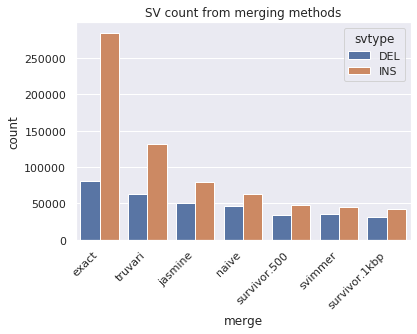

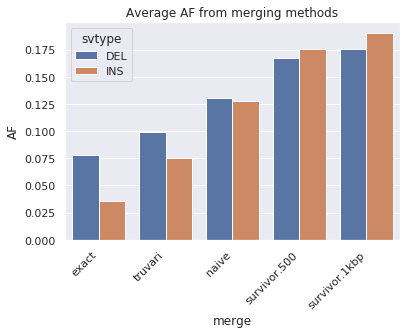

In [39]:
make_plots(grch38_summary, grch38_progorder)

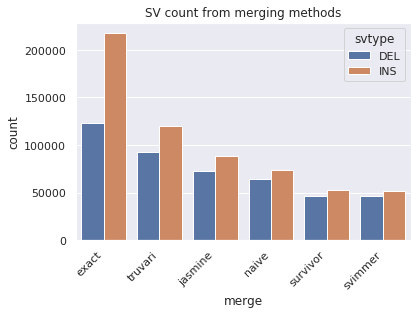

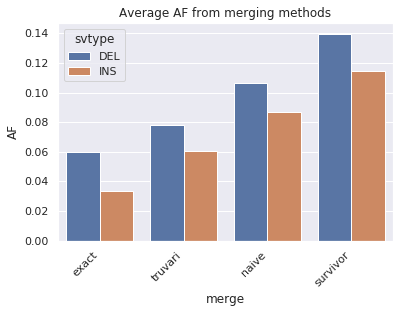

In [42]:
make_plots(chm13_summary, chm13_progorder)

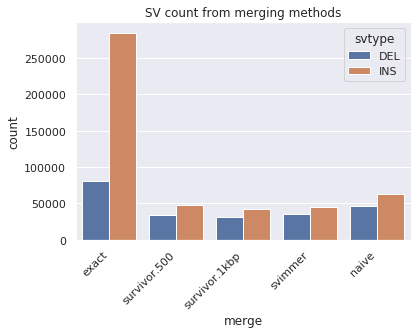

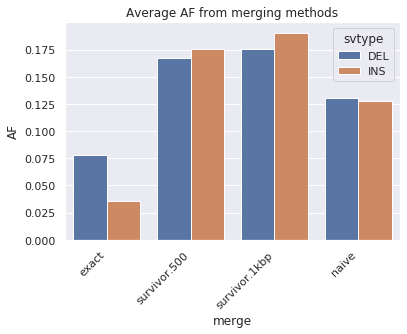

In [43]:
make_plots(grch38_summary, ["exact", "survivor.500", "survivor.1kbp", "svimmer", "naive"])